In [1]:
#unzipping the zip file into the colab
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

# Path to the zip file in Google Drive
zip_file_path = '/content/drive/MyDrive/Natural images/archive (10).zip'

# Directory to extract the contents of the zip file
extract_to_directory = '/content/extracted_files/'

# Create the directory if it doesn't exist
os.makedirs(extract_to_directory, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_directory)

print("Extraction completed.")


Mounted at /content/drive
Extraction completed.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix, classification_report
import os

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
# Set random seed for reproducibility
torch.manual_seed(42)

In [5]:
# Importing the data
train_dataset_path = '/content/extracted_files/seg_train/seg_train/'
validation_dataset_path = '/content/extracted_files/seg_test/seg_test/'

In [6]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [7]:
# Load the datasets
train_dataset = ImageFolder(root=train_dataset_path, transform=transform)
validation_dataset = ImageFolder(root=validation_dataset_path, transform=transform)


In [8]:
# Define dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)


In [9]:
# Get the label mappings
labels = train_dataset.classes
label_to_index = train_dataset.class_to_idx
index_to_label = {v: k for k, v in label_to_index.items()}

In [10]:
print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in index_to_label.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : buildings
1 : forest
2 : glacier
3 : mountain
4 : sea
5 : street


In [12]:
# Load pre-trained MNIST model
mnist_model = torchvision.models.resnet18(pretrained=True)
# Modify the last layer for the new classification task
num_ftrs = mnist_model.fc.in_features
mnist_model.fc = nn.Linear(num_ftrs, len(labels))  # Modify the last layer to match the number of classes
mnist_model = mnist_model.to(device)
print(mnist_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
# Define optimizer and loss function
optimizer = optim.Adam(mnist_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [14]:
# Training the model
num_epochs = 50
for epoch in range(num_epochs):
    mnist_model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = mnist_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

Epoch 1/50, Loss: 0.486166954940028
Epoch 2/50, Loss: 0.3376047228779092
Epoch 3/50, Loss: 0.27573537896122097
Epoch 4/50, Loss: 0.2555658494065047
Epoch 5/50, Loss: 0.21073216776913012
Epoch 6/50, Loss: 0.18837557398291954
Epoch 7/50, Loss: 0.14662221136263195
Epoch 8/50, Loss: 0.13358334927546
Epoch 9/50, Loss: 0.1081938057594799
Epoch 10/50, Loss: 0.08472620111180508
Epoch 11/50, Loss: 0.0782012199551548
Epoch 12/50, Loss: 0.07316683398894881
Epoch 13/50, Loss: 0.06031043532902188
Epoch 14/50, Loss: 0.05584226560280107
Epoch 15/50, Loss: 0.04863316212939353
Epoch 16/50, Loss: 0.045567031683846314
Epoch 17/50, Loss: 0.06669659506882793
Epoch 18/50, Loss: 0.03708593101647883
Epoch 19/50, Loss: 0.03866721735365587
Epoch 20/50, Loss: 0.03878880987738859
Epoch 21/50, Loss: 0.027240962625825527
Epoch 22/50, Loss: 0.04716438127691955
Epoch 23/50, Loss: 0.03767569138175768
Epoch 24/50, Loss: 0.019972628486154248
Epoch 25/50, Loss: 0.062386421328421114
Epoch 26/50, Loss: 0.02341294198715025


In [15]:
# Testing the model
mnist_model.eval()
correct = 0
total = 0
predictions = []
true_labels = []

with torch.no_grad():
    for data in validation_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = mnist_model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total}")

Test Accuracy: 89.5


In [17]:
# Specify the class labels based on your dataset
class_labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Print classification report
print(classification_report(true_labels, predictions, target_names=class_labels))

              precision    recall  f1-score   support

   buildings       0.94      0.85      0.89       437
      forest       0.93      0.99      0.96       474
     glacier       0.83      0.87      0.85       553
    mountain       0.87      0.80      0.83       525
         sea       0.92      0.94      0.93       510
      street       0.90      0.92      0.91       501

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.89      3000



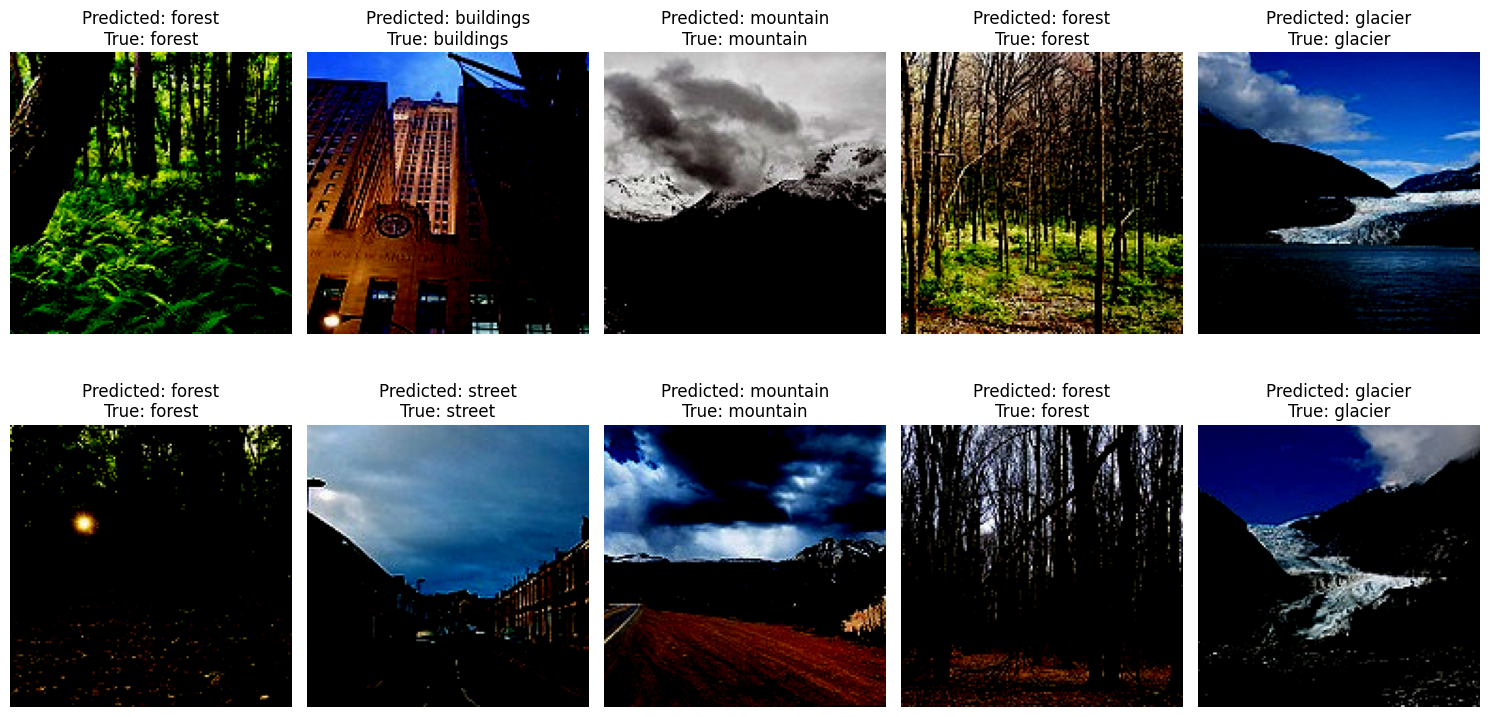

In [31]:
# Visualize predicted labels for a sample of validation dataset
num_images = 10  # Number of images to visualize
indices = np.random.choice(len(validation_dataset), num_images, replace=False)  # Randomly select indices
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 8))
for i, ax in enumerate(axes.flatten()):
    index = indices[i]
    img, label = validation_dataset[index]  # Get image and its original label
    img = img.numpy().squeeze()  # Convert image tensor to numpy array and remove the batch dimension
    if len(img.shape) == 3:
        img = img.transpose((1, 2, 0))  # If RGB image, transpose dimensions
    ax.imshow(img, cmap='gray' if len(img.shape) == 2 else None)  # Use 'gray' colormap for grayscale images
    predicted_label = index_to_label[predictions[index]]
    true_label = index_to_label[true_labels[index]]
    ax.set_title(f"Predicted: {predicted_label}\nTrue: {true_label}")  # Show predicted and true labels
    ax.axis('off')
plt.tight_layout()
plt.show()


In [32]:
# Define the file path where you want to save the model
model_path = 'intel_image_classification_model.pth'

# Save the entire model
torch.save(mnist_model, model_path)

print("Model saved successfully.")


Model saved successfully.
